HBox(children=(RadioButtons(description='Speed: ', index=1, options=('Wpm', 'Adjusted-Wpm'), value='Adjusted-Wpm'), RadioButtons(description='Accuracy: ', options=('Total-Error-Rate', 'Uncorrected-Error-Rate', 'Corrected-Error-Rate'), value='Total-Error-Rate')))

ToggleButtons(description='Metric: ', index=7, options=('Speed', 'Accuracy', 'Speed & Accuracy', 'Learning Curve', 'Speed Vs. Accuracy', 'KSPS Vs. Accuracy', 'Utilized Bandwidth', 'AdjWPM vs. KSPS'), value='AdjWPM vs. KSPS')

HBox(children=(Select(description='Participant: ', options=('All', '#1', '#2', '#3', '#4', '#5', '#6'), value='All'),))

<IPython.core.display.Javascript object>


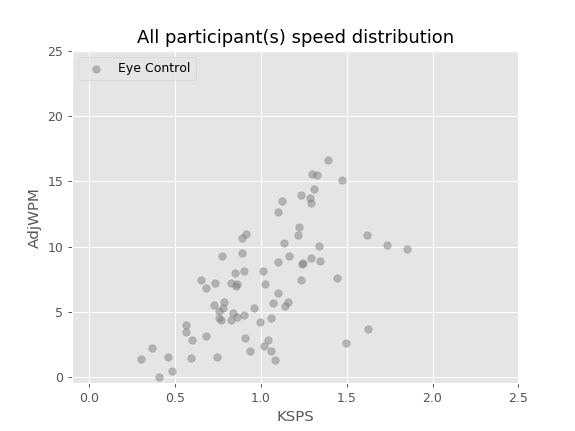

In [38]:
%matplotlib notebook	
import csv
from __future__ import print_function
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import numpy as np

class Sentence:
	# class variables here
	def __init__(self, participant, sentenceNo, testing):
		# instance variables here
		self.participant = participant
		self.sentenceNo = sentenceNo
		self.testing = testing		# 0: practice; 1: test
		self.keyboard = 0			# 0: win EyeControl; 1: tobii WinControl; 2: tobii Dwell-free
		self.wpm = 0.0
		self.adjWpm = 0.0
		self.totErrRate = 0.0
		self.uncErrRate = 0.0
		self.corErrRate = 0.0
		self.ksps = 0.0
		self.utilBand = 0.0

def readSentences(argFilename, argSentences):
	with open('Raw-Data/Logs/'+argFilename+'.csv') as csvDataFile:
		csvReader = csv.reader(csvDataFile)
		next(csvReader, None)
		next(csvReader, None)
		for row in csvReader:
			argSentences.append(Sentence(int(argFilename[0])-1, int(row[0]), int(row[1])))
			# exclude exceptions that the test participant didn't enter anything and skipped this sentence			
			if row[3] != 0:			
				sentences[-1].wpm = float(row[3])
				sentences[-1].adjWpm = float(row[4])
				sentences[-1].totErrRate = float(row[11])
				sentences[-1].uncErrRate = float(row[9])
				sentences[-1].corErrRate = float(row[10])				
				sentences[-1].keyboard = ord(argFilename[4])-65
				sentences[-1].ksps = float(row[6])
				sentences[-1].utilBand = float(row[14])

def clearCache():
	clear_output(wait=True)
	display(widgets.HBox([contrSpeed,contrErrRate]), contrMetric, widgets.HBox([contrPtcp]))
	# clear data storage
	dataStorage = [perPtcpWpm, perPtcpAdjWpm, perPtcpTotErrRate, perPtcpUncErrRate, perPtcpCorErrRate, perPtcpSentenceNo, perPtcpKsps, perPtcpUtilBand]
	for item in dataStorage:
		for index in range(amountPtcp*amountKeyboard):
			del item[index][:]

def onChange_speedOrAccuracy(change):
	if change['type']=='change' and change['name']=='value':
		plotsHub()

def onChange_metric(b):
	if b['type']=='change' and b['name']=='value':
		plotsHub()

def onChange_ptcp(change):
	if change['type']=='change' and change['name']=='value':
		plotsHub()

def plotsHub():
	clearCache()
	# extract sentences according to participant selection
	for item in sentences:
		if item.testing == 1:
			if contrPtcp.value != 'All':
				index = (int(contrPtcp.value[1])-1)*amountKeyboard+item.keyboard
				selectedPtcp = [int(contrPtcp.value[1])-1]
			else:
				index = item.participant*amountKeyboard+item.keyboard
				selectedPtcp = [i for i in range(amountPtcp)]
			if item.participant in selectedPtcp:
				perPtcpWpm[index].append(item.wpm)
				perPtcpAdjWpm[index].append(item.adjWpm)
				perPtcpTotErrRate[index].append(item.totErrRate)
				perPtcpUncErrRate[index].append(item.uncErrRate)
				perPtcpCorErrRate[index].append(item.corErrRate)
				perPtcpSentenceNo[index].append(item.sentenceNo)
				perPtcpKsps[index].append(item.ksps)
				perPtcpUtilBand[index].append(item.utilBand)
	filter()
	if 'Speed' == contrMetric.value:
		plotSpeed()
	elif 'Accuracy' == contrMetric.value:
		plotAccuracy()
	elif 'Speed & Accuracy' == contrMetric.value:
		plotSpeedNAccuracy()
	elif 'Learning' in contrMetric.value:
		plotLearningCurve()
	elif 'Speed Vs. Accuracy' == contrMetric.value:
		plotSpeedVsAccuracy()
	elif 'KSPS Vs. Accuracy' == contrMetric.value:
		plotKspsVsAccuracy()
	elif 'Utilized Bandwidth' == contrMetric.value:
		plotUtilizedBandwidth()	
	elif 'AdjWPM vs. KSPS' == contrMetric.value:
		plotSpeedVsSpeed()

def filter():
	pass
	# remove outliers that out of 90%

def plotSpeed():
	fig, ax = plt.subplots()
	ax.set(title=contrPtcp.value+' participant(s)'+' typing speed', ylabel='AdjWPM')
	plt.ylim(-0.1,25)
	yWpm = [[] for i in range(amountKeyboard)]
	if contrSpeed.value == 'Wpm':
		plotPerPtcpWpm = perPtcpWpm
	elif contrSpeed.value == 'Adjusted-Wpm':
		plotPerPtcpWpm = perPtcpAdjWpm
	for index in range(len(plotPerPtcpWpm)):
		for subIndex in range(len(plotPerPtcpWpm[index])):
			yWpm[index%amountKeyboard].append(plotPerPtcpWpm[index][subIndex])
	tmp1, tmp2, tmp3 = [[0 for i in range(amountKeyboard)] for j in range(3)]
# adjust keyboard order as WinControl, EyeControl, and Dwell-free
	plt.boxplot(yWpm[0], positions=[plotXPosition[1]], showfliers=True, patch_artist=True, 
					boxprops=dict(facecolor=color[0]), medianprops=dict(linewidth=1, linestyle=None, color='white'),widths=0.3)
	plt.boxplot(yWpm[1], positions=[plotXPosition[0]], showfliers=True, patch_artist=True, 
					boxprops=dict(facecolor=color[1]), medianprops=dict(linewidth=1, linestyle=None, color='white'),widths=0.3)
	plt.boxplot(yWpm[2], positions=[plotXPosition[2]], showfliers=True, patch_artist=True, 
					boxprops=dict(facecolor=color[2]), medianprops=dict(linewidth=1, linestyle=None, color='white'),widths=0.3)
	plt.xlim(min(plotXPosition)-1, max(plotXPosition)+1)	
	plt.xticks(plotXPosition, axisKeybd)
	fig.savefig('plotSpeed_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotAccuracy():
	fig, ax = plt.subplots()
	ax.set(title=contrPtcp.value+' participant(s)'+' typing error rate', ylabel='TotErrorRate')
	plt.ylim(-0.01,1)
	yErrRate = [[] for i in range(amountKeyboard)]
	if contrErrRate.value == 'Total-Error-Rate':
		plotPerPtcpErrRate = perPtcpTotErrRate
	elif contrErrRate.value == 'Uncorrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpUncErrRate
	elif contrErrRate.value == 'Corrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpCorErrRate
	for index in range(len(plotPerPtcpErrRate)):
		for subIndex in range(len(plotPerPtcpErrRate[index])):
			yErrRate[index%amountKeyboard].append(plotPerPtcpErrRate[index][subIndex])
	tmp1, tmp2, tmp3 = [[0 for i in range(amountKeyboard)] for j in range(3)]
	# adjust keyboard order as WinControl, EyeControl, and Dwell-free
	plt.boxplot(yErrRate[0], positions=[plotXPosition[1]], showfliers=True, patch_artist=True, 
					boxprops=dict(facecolor=color[0]), medianprops=dict(linewidth=1, linestyle=None, color='white'),widths=0.3)
	plt.boxplot(yErrRate[1], positions=[plotXPosition[0]], showfliers=True, patch_artist=True, 
					boxprops=dict(facecolor=color[1]), medianprops=dict(linewidth=1, linestyle=None, color='white'),widths=0.3)
	plt.boxplot(yErrRate[2], positions=[plotXPosition[2]], showfliers=True, patch_artist=True, 
					boxprops=dict(facecolor=color[2]), medianprops=dict(linewidth=1, linestyle=None, color='white'),widths=0.3)
	plt.xlim(min(plotXPosition)-1, max(plotXPosition)+1)	
	plt.xticks(plotXPosition, axisKeybd)
	fig.savefig('plotAccuracy_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotSpeedNAccuracy():
	fig, ax = plt.subplots()
	ax.set(title=contrPtcp.value+' participant(s)'+' average typing speed', xlabel='Keyboard', ylabel='AdjWPM')
	plt.ylim(0,15.2)
	yWpm, sdTotErrRate = ([[] for i in range(amountKeyboard)] for j in range(2))
	if contrSpeed.value == 'Wpm':
		plotPerPtcpWpm = perPtcpWpm
	elif contrSpeed.value == 'Adjusted-Wpm':
		plotPerPtcpWpm = perPtcpAdjWpm
	if contrErrRate.value == 'Total-Error-Rate':
		plotPerPtcpErrRate = perPtcpTotErrRate
	elif contrErrRate.value == 'Uncorrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpUncErrRate
	elif contrErrRate.value == 'Corrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpCorErrRate
	for index in range(len(plotPerPtcpWpm)):
		for subIndex in range(len(plotPerPtcpWpm[index])):
			yWpm[index%amountKeyboard].append(plotPerPtcpWpm[index][subIndex])
			sdTotErrRate[index%amountKeyboard].append(plotPerPtcpErrRate[index][subIndex])
	for i in range(amountKeyboard):
		plt.bar(i+1,np.mean(yWpm[i]),0.5,color=color[i],label=labelKeybd[i],alpha=0.6)		
	for i in range(amountKeyboard):
		if i == 0:
			eb = plt.errorbar(i+1,np.mean(yWpm[i]),np.mean(sdTotErrRate[i])*np.mean(yWpm[i]),
						color='gray',elinewidth=1,capsize=3,label='Associated error range')
		else:
			eb = plt.errorbar(i+1,np.mean(yWpm[i]),np.mean(sdTotErrRate[i])*np.mean(yWpm[i]),
						color='gray',elinewidth=1,capsize=3)
		eb[-1][0].set_linestyle('--')
	plt.xlim(min(plotXPosition)-1, max(plotXPosition)+1)	
	plt.xticks(plotXPosition, axisKeybd)
	ax.legend(loc='upper left')	
	fig.savefig('plotSpeedNAccuracy_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotLearningCurve():
	fig, ax = plt.subplots()
	if contrSpeed.value == 'Wpm':
		plotPerPtcpWpm = perPtcpWpm
	elif contrSpeed.value == 'Adjusted-Wpm':
		plotPerPtcpWpm = perPtcpAdjWpm
	if contrErrRate.value == 'Total-Error-Rate':
		plotPerPtcpErrRate = perPtcpTotErrRate
	elif contrErrRate.value == 'Uncorrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpUncErrRate
	elif contrErrRate.value == 'Corrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpCorErrRate
	if contrPtcp.value != 'All':
		for index in range(len(plotPerPtcpWpm)):
			if len(plotPerPtcpWpm[index]):
				sdError = [a*b for a,b in zip(plotPerPtcpWpm[index], plotPerPtcpErrRate[index])]
				eb = plt.errorbar(perPtcpSentenceNo[index],plotPerPtcpWpm[index],sdError,
					fmt='.-',color=color[index],elinewidth=6,capsize=3,label=labelKeybd[index],alpha=0.5)
				eb[-1][0].set_linestyle('--')
	else:
		yPerSentenceWpm, yPerSentenceTotErrRate = ([[([0]*15) for i in range(amountPtcp)] for j in range(amountKeyboard)] for k in range(2))
		tmpPerSentenceNo = [j for j in range(4,19)]
		for index in range(len(plotPerPtcpWpm)):
			for indexSub in range(len(plotPerPtcpWpm[index])):
				i = tmpPerSentenceNo.index(perPtcpSentenceNo[index][indexSub])
				yPerSentenceWpm[index%amountKeyboard][index//amountKeyboard][i] = plotPerPtcpWpm[index][indexSub]
				yPerSentenceTotErrRate[index%amountKeyboard][index//amountKeyboard][i] = plotPerPtcpErrRate[index][indexSub]
		yWpm, sdTotErrRate = ([([0]*15)for p in range(amountKeyboard)] for q in range(2))
		for i in range(amountKeyboard):
			for j in range(15):
				bufferWpm, bufferErrRate = ([] for q in range(2))
				for k in range(amountPtcp):
					if yPerSentenceWpm[i][k][j] != 0:
						bufferWpm.append(yPerSentenceWpm[i][k][j])
						bufferErrRate.append(yPerSentenceTotErrRate[i][k][j])
				if len(bufferWpm) <= amountPtcp: # threshold = 0.3
					yWpm[i][j] = np.mean(bufferWpm)
					sdTotErrRate[i][j] = np.mean(bufferErrRate)
				else:
					yWpm[i][j] = 0
					sdTotErrRate[i][j] = 0
			# eb = plt.errorbar([q for q in range(4,19)], yWpm[i], sdTotErrRate[i],
			# 				fmt='.-',color=color[i],elinewidth=6,capsize=3,label=labelKeybd[i],alpha=0.5)
			plt.scatter([q for q in range(4,19)], yWpm[i], color=color[i], s=12)
			plt.plot([q for q in range(4,19)], yWpm[i], color=color[i], label=labelKeybd[i])
			# plt.plot([q for q in range(4,19)], sdTotErrRate[i], color=color[i], label=labelKeybd[i],alpha=0.5)	
			# eb[-1][0].set_linestyle('--')
	ax.legend(loc='upper left')
	ax.set(title=contrPtcp.value+' participant(s)'+' learning curve (a)', xlabel='Sentence number', ylabel='AdjWPM')
	plt.ylim(0, 15.2)
	# plt.ylim(0, 1)
	fig.savefig('plotLearningCurve_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotSpeedVsAccuracy():
	xSpeed, yErrRate = ([[], [], []] for i in range(2))
	if contrSpeed.value == 'Wpm':
		plotPerPtcpWpm = perPtcpWpm
	elif contrSpeed.value == 'Adjusted-Wpm':
		plotPerPtcpWpm = perPtcpAdjWpm
	if contrErrRate.value == 'Total-Error-Rate':
		plotPerPtcpErrRate = perPtcpTotErrRate
	elif contrErrRate.value == 'Uncorrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpUncErrRate
	elif contrErrRate.value == 'Corrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpCorErrRate
	for index in range(len(plotPerPtcpWpm)):
		if len(plotPerPtcpWpm[index]):
			for indexSub in range(len(plotPerPtcpWpm[index])):
				xSpeed[index%amountKeyboard].append(plotPerPtcpWpm[index][indexSub])
				yErrRate[index%amountKeyboard].append(plotPerPtcpErrRate[index][indexSub])
	fig, ax = plt.subplots()
	for i in range(amountKeyboard):
		plt.scatter(xSpeed[i], yErrRate[i], color=color[i], label=labelKeybd[i], alpha=0.5)
	ax.legend(loc='upper center')
	ax.set_xscale('log', basex=2)
	ax.set(title=contrPtcp.value+' participant(s)'+' speed vs. error rate', xlabel='WPM', ylabel='Total Error Rate')
	plt.ylim(-0.05, 1.05)
	plt.xlim(0.2,40)
	fig.savefig('plotWpmVsAccuracy_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotKspsVsAccuracy():
	xSpeed, yErrRate = ([[], [], []] for i in range(2))
	plotPerPtcpWpm = perPtcpKsps
	if contrErrRate.value == 'Total-Error-Rate':
		plotPerPtcpErrRate = perPtcpTotErrRate
	elif contrErrRate.value == 'Uncorrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpUncErrRate
	elif contrErrRate.value == 'Corrected-Error-Rate':
		plotPerPtcpErrRate = perPtcpCorErrRate
	for index in range(len(plotPerPtcpWpm)):
		if len(plotPerPtcpWpm[index]):
			for indexSub in range(len(plotPerPtcpWpm[index])):
				xSpeed[index%amountKeyboard].append(plotPerPtcpWpm[index][indexSub])
				yErrRate[index%amountKeyboard].append(plotPerPtcpErrRate[index][indexSub])
	fig, ax = plt.subplots()
	for i in range(amountKeyboard):
		print(np.std(xSpeed[i]))
		plt.scatter(xSpeed[i], yErrRate[i], color=color[i], label=labelKeybd[i], alpha=0.5)
	ax.legend(loc='upper center')
	# ax.set_xscale('log', basex=2)
	ax.set(title=contrPtcp.value+' participant(s)'+' speed vs. error rate', xlabel='KSPS', ylabel='Total Error Rate')
	plt.ylim(-0.05, 1.05)
	plt.xlim(-0.05,2.5)
	fig.savefig('plotKspsVsAccuracy_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotUtilizedBandwidth():
	fig, ax = plt.subplots()
	plotPerPtcpWpm = perPtcpUtilBand
	if contrPtcp.value != 'All':
		for index in range(len(plotPerPtcpWpm)):
			if len(plotPerPtcpWpm[index]):
				eb = plt.plot(perPtcpSentenceNo[index],plotPerPtcpWpm[index],label=labelKeybd[index],alpha=0.5,color=color[index])
	else:
		yPerSentenceWpm= ([[([0]*15) for i in range(amountPtcp)] for j in range(amountKeyboard)])
		tmpPerSentenceNo = [j for j in range(4,19)]
		for index in range(len(plotPerPtcpWpm)):
			for indexSub in range(len(plotPerPtcpWpm[index])):
				i = tmpPerSentenceNo.index(perPtcpSentenceNo[index][indexSub])
				yPerSentenceWpm[index%amountKeyboard][index//amountKeyboard][i] = plotPerPtcpWpm[index][indexSub]
		yWpm, yWpmMean = ([([0]*15) for p in range(amountKeyboard)] for q in range(2))
		for i in range(amountKeyboard):
			for j in range(15):
				bufferWpm = []
				for k in range(amountPtcp):
					if yPerSentenceWpm[i][k][j] != 0:
						bufferWpm.append(yPerSentenceWpm[i][k][j])
				if len(bufferWpm) <= amountPtcp: # threshold = 0.3
					yWpm[i][j] = np.mean(bufferWpm)
				else:
					yWpm[i][j] = 0

			yWpmMean[i] = np.mean(yWpm[i])
			mean = plt.plot([q for q in range(4,19)], [yWpmMean[i] for q in range(4,19)], '--', alpha=0.5, color=color[i])
			eb = plt.plot([q for q in range(4,19)], yWpm[i], label=labelKeybd[i],alpha=0.5, color=color[i])
	ax.legend(loc='lower center')
	plt.ylim(0,1)
	ax.set(title=contrPtcp.value+' participant(s)'+' utilized bandwidth', xlabel='Sentence no.', ylabel='Utilized Bandwidth')
	fig.savefig('plotUtilBand_'+contrPtcp.value+'.png', bbox_inches='tight')

def plotSpeedVsSpeed():
	plotAdjWPM = perPtcpAdjWpm
	plotKSPS = perPtcpKsps
	xKSPS, yAdjWPM = ([[], [], []] for i in range(2))
	for index in range(len(plotAdjWPM)):
		if len(plotAdjWPM[index]):
			for indexSub in range(len(plotAdjWPM[index])):
				xKSPS[index%amountKeyboard].append(plotKSPS[index][indexSub])
				yAdjWPM[index%amountKeyboard].append(plotAdjWPM[index][indexSub])
	fig, ax = plt.subplots()
	# for i in range(amountKeyboard):
	# 	plt.scatter(xKSPS[i], yAdjWPM[i], color=color[i], label=labelKeybd[i], alpha=0.5)
	i=0
	plt.scatter(xKSPS[i], yAdjWPM[i], color=color[i], label=labelKeybd[i], alpha=0.5)

	ax.legend(loc='upper left')
	ax.set(title=contrPtcp.value+' participant(s)'+' speed distribution', xlabel='KSPS', ylabel='AdjWPM')
	plt.ylim(-0.5, 25)
	plt.xlim(-0.1,2.5)
	fig.savefig('plotAdjWPMvsKSPS'+contrPtcp.value+'.png', bbox_inches='tight')


if __name__=="__main__":
	amountPtcp=6
	amountKeyboard=3
	sentences=[]
	perPtcpWpm, perPtcpAdjWpm, perPtcpTotErrRate, perPtcpUncErrRate, perPtcpCorErrRate, perPtcpSentenceNo, perPtcpKsps, perPtcpUtilBand = ([[] for j in range(amountPtcp*amountKeyboard)] for i in range(8))
	plotXPosition = [1,2,3]
	labelKeybd = ['Eye Control', 'Win Control', 'Dwell-free'] * 6
	axisKeybd = ['Win Control', 'Eye Control', 'Dwell-free'] * 6
	color = ['gray', '#01ac66','#DD7E50'] * 6 

	# filenames = ['1_kbB_logs', 
	# 			'2_kbA_logs', '2_kbB_logs', '2_kbC_logs',
	# 			'3_kbA_logs', '3_kbB_logs', '3_kbC_logs',
	# 			'4_kbA_logs', '4_kbB_logs', '4_kbC_logs',
	# 			'5_kbA_logs', '5_kbB_logs', '5_kbC_logs',
	# 			'6_kbA_logs', '6_kbB_logs', '6_kbC_logs']
	filenames = ['2_kbA_logs', '2_kbB_logs', '2_kbC_logs',
				'3_kbA_logs', '3_kbB_logs', '3_kbC_logs',
				'4_kbA_logs', '4_kbB_logs', '4_kbC_logs',
				'5_kbA_logs', '5_kbB_logs', '5_kbC_logs',
				'6_kbA_logs', '6_kbB_logs', '6_kbC_logs']


	for item in filenames:
		readSentences(item, sentences)
	print(len(sentences))


	contrSpeed = widgets.RadioButtons(
		options=['Wpm', 'Adjusted-Wpm'],
		description='Speed: ',
		value='Wpm',
		disabled=False
		)
	contrErrRate = widgets.RadioButtons(
		options=['Total-Error-Rate', 'Uncorrected-Error-Rate', 'Corrected-Error-Rate'],
		description='Accuracy: ',
		value='Total-Error-Rate',
		disabled=False
		)
	contrMetric = widgets.ToggleButtons(
		options=['Speed', 'Accuracy', 'Speed & Accuracy', 'Learning Curve', 'Speed Vs. Accuracy', 'KSPS Vs. Accuracy', 'Utilized Bandwidth', 'AdjWPM vs. KSPS'],
		description='Metric: ',
		value='Utilized Bandwidth',
		disabled=False
		)
	contrPtcp = widgets.Select(
		options=['All', '#1', '#2', '#3', '#4', '#5', '#6'],
		description='Participant: ',
		value='All',
		disabled=False
		)
	display(widgets.HBox([contrSpeed,contrErrRate]), contrMetric, widgets.HBox([contrPtcp]))
	contrMetric.observe(onChange_metric)
	contrPtcp.observe(onChange_ptcp)
	contrSpeed.observe(onChange_speedOrAccuracy)
	contrErrRate.observe(onChange_speedOrAccuracy)

In [ ]:
# Wpm: words per minute regardless its correctness
# Adjusted-Wpm: words per minute regarding corrected input
# otal-Error-Rate: the ratio of error (both corrected and uncorrected) and the whole input stream
# Uncorrected-Error-Rate: the ratio of uncorrected error and the whole input stream
# Corrected-Error-Rate: the ratio of corrected error and the whole input stream